# Spline Regression

In the first steps, I followed the example by Christopher Krapu (https://ckrapu.github.io/2018/07/09/Spline-Regression.html).

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm

import pandas as pd
%matplotlib inline

In [56]:
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'

In [57]:
def build_B_spline_deg_zero_degree_basis_fns(breaks, x):
    """Build B spline 0 order basis coefficients with knots at 'breaks'. 
    N_{i,0}(x) = { 1 if u_i <= x < u_{i+1}, 0 otherwise }
    """
    expr = []
    expr.append(tt.switch(x<breaks[1], 1, 0))
    for i in range(1, len(breaks)-2):
        l_break = breaks[i]
        u_break = breaks[i+1]
        expr.append(
            tt.switch((x>=l_break)&(x<u_break), 1, 0) )
    expr.append( tt.switch(x>=breaks[-2], 1, 0) )
    return expr

In [58]:
def build_B_spline_higher_degree_basis_fns(
        breaks, prev_degree_coefs, degree, x):
    """Build the higer order B spline basis coefficients
    N_{i,p}(x) = ((x-u_i)/(u_{i+p}-u_i))N_{i,p-1}(x) \
               + ((u_{i+p+1}-x)/(u_{i+p+1}-u_{i+1}))N_{i+1,p-1}(x)
    """
    assert degree > 0
    coefs = []
    for i in range(len(prev_degree_coefs)-1):
        alpha1 = (x-breaks[i])/(breaks[i+degree]-breaks[i]+1e-12)
        alpha2 = (breaks[i+degree+1]-x)/(breaks[i+degree+1]-breaks[i+1]+1e-12)
        coef = alpha1*prev_degree_coefs[i] + alpha2*prev_degree_coefs[i+1]
        coefs.append(coef)
    return coefs

In [59]:
def build_B_spline_basis_fns(breaks, max_degree, x):
    curr_basis_coefs = build_B_spline_deg_zero_degree_basis_fns(breaks, x)
    for degree in range(1, max_degree+1):
        curr_basis_coefs = build_B_spline_higher_degree_basis_fns(
            breaks, curr_basis_coefs, degree, x)
    return curr_basis_coefs

In [60]:
def spline_fn_expr(breaks, intercepts, degree, x):
    basis_fns = build_B_spline_basis_fns(breaks, degree, x)
    spline = 0
    for i, basis in enumerate(basis_fns):
        spline += intercepts[i]*basis
    return spline

In [61]:
def compile_spline(data,n_bins,degree,intercepts):
    breaks = np.histogram(data, n_bins)[1][1:-1]
    for i in range(degree+1):
        breaks = np.insert(breaks, 0, data.min()-1e-6)
        breaks = np.append(breaks, data.max()+1e-6)
    xs = tt.vector(dtype=theano.config.floatX)
    f = theano.function([intercepts, xs],spline_fn_expr(breaks, intercepts, degree, xs))
    return f

In [62]:
domain = np.linspace(-4,4,100)
n_bins = 2
degree = 4
coefficients = tt.vector(dtype=theano.config.floatX)
spline = compile_spline(domain,n_bins,degree,coefficients)

In [63]:
x = np.asarray([-3.69,  1.60, -2.05, -1.63, -3.07,
       -1.06,  3.64, -1.61, -2.58, -3.57,
       -1.55, -1.93, -3.94,  3.51, -0.17,
       -3.92,  0.52,  3.06 ,  3.40, -0.21])
true_coef = np.asarray([ 0.82, -0.34,  1.75, -0.78,  0.25,
       -0.76,  0.59,  1.13 ,  1.32])

Text(0, 0.5, 'f(x)')

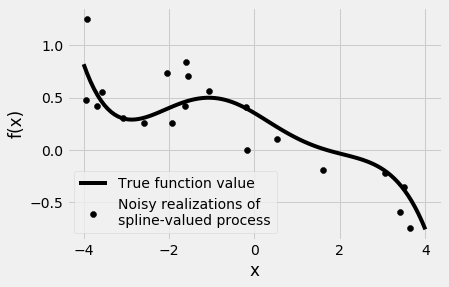

In [65]:
true_mean   = spline(true_coef,domain)
y_noiseless = spline(true_coef,x)

y_noisy = y_noiseless + np.random.randn(x.shape[0])*0.2

plt.style.use('fivethirtyeight')
plt.scatter(x,y_noisy,label = 'Noisy realizations of \nspline-valued process',color='k')
plt.plot(domain,true_mean,color='k',label = 'True function value')
plt.legend(loc = 'lower left')
plt.xlabel('x')
plt.ylabel('f(x)')

# Estimating spline parameters

Now, I would like to use the same technique on my data in order to estimate spline parameters for creating a representative function. My data shows a linear trend first and then changes into a quadratic dependency.

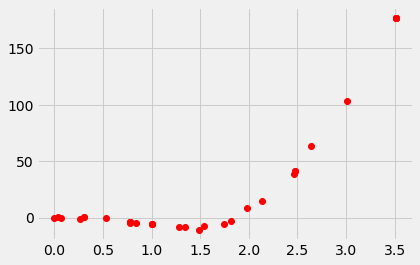

In [78]:
x = np.array([0.        , 0.03364583, 0.06396991, 0.26822917, 0.30600694,
       0.30619213, 0.53136574, 0.7740625 , 0.77430556, 0.7750463 ,
       0.77590278, 0.8390625 , 1.00467593, 1.0059375 , 1.00693287,
       1.2787963 , 1.34362269, 1.48939815, 1.53609954, 1.74604167,
       1.81266204, 1.97753472, 2.14038194, 2.46284722, 2.47528935,
       2.47613426, 2.63649306, 3.01434028, 3.51010417, 3.51114583,
       3.51288194, 3.5137037 ])
y_noisy = np.array([-1.79115574e-01,  6.25958906e-01, -6.47491364e-01, -1.29351477e+00,
        2.64397486e-01,  3.63929988e-01, -9.37538928e-02, -3.98027000e+00,
       -4.06193312e+00, -4.17972094e+00, -4.84284664e+00, -4.53880276e+00,
       -5.52900380e+00, -5.52900380e+00, -5.52900380e+00, -8.22763816e+00,
       -8.05190714e+00, -1.06254842e+01, -6.94957746e+00, -5.19495296e+00,
       -3.17329480e+00,  8.30268444e+00,  1.48384712e+01,  3.85102710e+01,
        4.15606490e+01,  4.15606490e+01,  6.35088300e+01,  1.03625013e+02,
        1.77265790e+02,  1.77265790e+02,  1.77265790e+02,  1.77265790e+02])

plt.plot(x, y_noisy, 'ro')

In [79]:
n_bins = 2
degree = 4
num_coef = n_bins + degree + 1 # Restraint that must be obeyed by parameter sets of B-splines
domain   = np.linspace(x.min(),x.max(),20)

In [80]:
breaks = np.histogram(domain, n_bins)[1][1:-1]
print(breaks)
for i in range(degree+1):
    breaks = np.insert(breaks, 0, domain.min()-1e-6)
    breaks = np.append(breaks, domain.max()+1e-6)

[1.75685185]


This break seems quite a good estimate, since the function is linear for smaller values and quadratic afterwards. 

In [113]:
with pm.Model() as model:   
    coef = pm.Flat('coef',shape = num_coef,testval = np.zeros(num_coef))
    x_as_tensor = tt.as_tensor(x)
    s = spline_fn_expr(breaks, coef, degree, x_as_tensor)

In [114]:
SAMPLES = 2000
BURN = 600 

with model:
    sigma  = pm.HalfCauchy('sigma',beta=2.0)
    y_hat  = pm.Deterministic('y_hat',s)
    y      = pm.Normal('y',mu = y_hat,sd = sigma,observed = y_noisy)
    #step = pm.Metropolis()
    trace  = pm.sample(SAMPLES, chains=2, tune=BURN)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, coef]
Sampling 2 chains: 100%|██████████| 5200/5200 [01:13<00:00, 70.29draws/s] 
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Apparently, the sampling process faced some problems. I already tried to use a greater sample size, but I didn't change much in the outcoming fit.

In [111]:
T = len(domain)
n_samples = 500
function_samples= np.zeros([T,n_samples])
for i in range(n_samples):
    coef_sample = trace['coef'][i,:]
    function_samples[:,i] = spline(coef_sample[:],domain)
    
ci = np.percentile(function_samples,[95,50,5],axis = 1)
#ci = np.percentile(function_samples,[65,45,5],axis = 1)
trace['coef'][i,:]

array([-2.17213140e+00,  7.46408966e+00, -2.54286865e+01, -1.72642752e+01,
        1.06338317e+02,  1.76751366e+02, -2.55739008e+99])

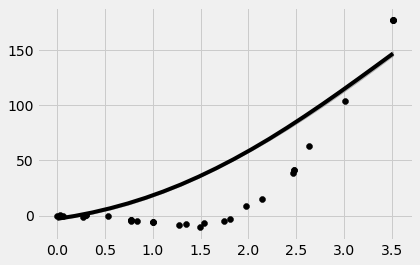

In [112]:
plt.fill_between(domain,ci[0],ci[2],color='0.5',alpha = 0.5,label = '90% CI')
plt.scatter(x,y_noisy,label = 'Noisy realizations of \nspline-valued process',color='k')
plt.plot(domain, ci[1],color='k',label = 'True function value')
#plt.legend(loc = 'upper left')
#plt.xlabel('x')
#plt.ylabel('f(x)')